# **Insight Flow**  
### **Intro to Datascience Project**  
Travis Draper  
Dane Bartholomew  
Alex Beams

Video: https://youtu.be/c49dI6thmiY

## Project Motivation
Utah is an especially dry state, with water shortages threatening qualitiy of life for everybody.  Temperatures have apparently been increasing over the years, and we wanted to see whether the data reflect this.  We also were curious to learn something about our state's climate -- whether there are qualitatively different types of climates within the state that might be more likely to experience drought, for example. 

Luckily, the United States Department of Agriculture manages SNOTEL sites throughout the nation to do this.  These sites have tracked precipitation since about 1978 and, more recently (~1996 for some sites; as recently as 2006 for others), snowfall and temperature. More sites have come online since the program commenced, so more recent years have more data.  That said, precipitation has been tracked -- at least partially -- since 1978. We will try to see what the climate trends have been in Utah over the years, expecting to see increases in temperature over time.  Also, we investigate whether these data can tell us whether there are any areas in the state particularly at risk of water shortage.


## The Data

We obtained the data from this site: https://wcc.sc.egov.usda.gov/reportGenerator/view/customMultipleStationReport/monthly/start_of_period/state=%22UT%22%20AND%20network=%22SNTLT%22,%22SNTL%22%20AND%20outServiceDate=%222100-01-01%22%7Cname/-576,0/stationId,name,elevation,PREC::value,WTEQ::value,SNWD::value,TAVG::value,TMAX::value,TMIN::value?fitToScreen=false

We saved it as a .csv file for convenience (the page generally takes a fair amount of time to load.)

Below we load the .csv file and describe its contents.  Later, we will want to obtain latitude and longitude data for the SNOTEL sites to connect information about climate with geographic location.  This information is not included in the data, so we have to scrape it from a website like this one:

https://wcc.sc.egov.usda.gov/nwcc/site?sitenum=1097&state=ut



This is the first cell where we focused primarily on leaving code notes, and importing necessary modules for the whole document.

In [10]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
# This next line tells jupyter to render the images inline
%matplotlib inline
import numpy as np

This next block is where we import the csv file containing all of the data we are going to work with.  There are several things that we are still trying to figure out such as how to deal with the missing data. There is also the question of trying to do web scraping to get more location data for each of the project sites.

In [11]:
#snowfall = pd.read_csv("snotel_simple.csv")
snowfall = pd.read_csv('Snotel_big.csv')
snowfall.shape

(39643, 11)

# Basic Data Cleanup and Early Exploratory Analysis

Here we are trying to figure out a way to work with the dates given so that we can actually run through the data as a time series.  Breaking stuff up was surprisingly difficult.

In [12]:
dat = snowfall[['Date', 'Precipitation Accumulation (in) Start of Month Values']]
grouped = dat.groupby('Date').mean()

In [13]:
dates = snowfall['Date'].str.split('-')
int(dates[0][1])

94

In [14]:
yearvec = []
for i in range(len(dates)):
    if(int(dates[i][1]) < 19):
        year = 2000 + int(dates[i][1])
    else:
        year = 1900 + int(dates[i][1])
    yearvec.append(year)

In [15]:
snowfall['year'] = yearvec

In [16]:
monthvec = []
for i in range(len(dates)):
    monthvec.append(dates[i][0])
    
snowfall['month'] = monthvec

In [67]:
print("The years of the data set span " + str(min(snowfall["year"])) + " to " + str(max(snowfall["year"])) + ".")

The years of the data set span 1978 to 2018.


Let's look at some basic descriptive statistics for the complete dataset (dropping rows with missing data):

In [68]:
snowfall.dropna().iloc[:,2:13].describe()

Station Id  Elevation (ft)  \
count  17161.000000    17161.000000   
mean     719.468504     8634.193404   
std      286.215697     1052.446637   
min      329.000000     5972.000000   
25%      461.000000     7944.000000   
50%      643.000000     8709.000000   
75%      971.000000     9414.000000   
max     1280.000000    10943.000000   

       Precipitation Accumulation (in) Start of Month Values  \
count                                       17161.000000       
mean                                           15.560364       
std                                            12.464006       
min                                             0.000000       
25%                                             5.400000       
50%                                            14.000000       
75%                                            22.700000       
max                                            82.600000       

       Precipitation Increment (in)  \
count                  17161.000000   
mean                       2.574157   
std                        1.981221   
min                        0.000000   
25%                        1.200000   
50%                        2.100000   
75%                        3.500000   
max                       24.600000   

       Snow Water Equivalent (in) Start of Month Values  \
count                                      17161.000000   
mean                                           4.835464   
std                                            7.771629   
min                                            0.000000   
25%                                            0.000000   
50%                                            0.400000   
75%                                            7.500000   
max                                           75.100000   

       Snow Depth (in) Start of Month Values  Air Temperature Average (degF)  \
count                           17161.000000                    17161.000000   
mean                               16.195909                       40.122137   
std                                22.512552                       13.677888   
min                                 0.000000                       11.000000   
25%                                 0.000000                       28.000000   
50%                                 2.000000                       38.000000   
75%                                29.000000                       52.000000   
max                               173.000000                       75.000000   

       Air Temperature Maximum (degF)  Air Temperature Minimum (degF)  \
count                    17161.000000                    17161.000000   
mean                        63.693316                       15.717849   
std                         12.699946                       17.634706   
min                         32.000000                      -40.000000   
25%                         53.000000                        2.000000   
50%                         63.000000                       15.000000   
75%                         75.000000                       30.000000   
max                        104.000000                       56.000000   

               year  
count  17161.000000  
mean    2011.220034  
std        4.388287  
min     1996.000000  
25%     2008.000000  
50%     2012.000000  
75%     2015.000000  
max     2018.000000

Let's look at a correlation matrix for this same subset:

In [65]:
snowfall.dropna().iloc[:,3:].corr()

Elevation (ft)  \
Elevation (ft)                                            1.000000   
Precipitation Accumulation (in) Start of Month ...       -0.074690   
Precipitation Increment (in)                             -0.031348   
Snow Water Equivalent (in) Start of Month Values          0.067861   
Snow Depth (in) Start of Month Values                     0.097964   
Air Temperature Average (degF)                           -0.189102   
Air Temperature Maximum (degF)                           -0.219786   
Air Temperature Minimum (degF)                           -0.173244   
year                                                     -0.021744   
Longitude                                                -0.327810   
Latitude                                                 -0.225275   

                                                    Precipitation Accumulation (in) Start of Month Values  \
Elevation (ft)                                                                              -0.074690       
Precipitation Accumulation (in) Start of Month ...                                           1.000000       
Precipitation Increment (in)                                                                -0.037268       
Snow Water Equivalent (in) Start of Month Values                                             0.276449       
Snow Depth (in) Start of Month Values                                                        0.166702       
Air Temperature Average (degF)                                                               0.544178       
Air Temperature Maximum (degF)                                                               0.501250       
Air Temperature Minimum (degF)                                                               0.542718       
year                                                                                        -0.094068       
Longitude                                                                                    0.074608       
Latitude                                                                                     0.179720       

                                                    Precipitation Increment (in)  \
Elevation (ft)                                                         -0.031348   
Precipitation Accumulation (in) Start of Month ...                     -0.037268   
Precipitation Increment (in)                                            1.000000   
Snow Water Equivalent (in) Start of Month Values                        0.322147   
Snow Depth (in) Start of Month Values                                   0.350026   
Air Temperature Average (degF)                                         -0.365234   
Air Temperature Maximum (degF)                                         -0.365270   
Air Temperature Minimum (degF)                                         -0.288649   
year                                                                   -0.076969   
Longitude                                                               0.038948   
Latitude                                                                0.152451   

                                                    Snow Water Equivalent (in) Start of Month Values  \
Elevation (ft)                                                                              0.067861   
Precipitation Accumulation (in) Start of Month ...                                          0.276449   
Precipitation Increment (in)                                                                0.322147   
Snow Water Equivalent (in) Start of Month Values                                            1.000000   
Snow Depth (in) Start of Month Values                                                       0.951803   
Air Temperature Average (degF)                                                             -0.343837   
Air Temperature Maximum (degF)                                                             -0.342939   
Air Temperature Minimum (degF)                               

Here we get the first early data exploration.  The precipitation increment is the value that we are most interested in here for actually calculating rainfall, and snowfall.  We still have a lot of work to do before we can fully work on the temperature data. The Precipitation Increment is the amount of rainfall or snowfall that occurs within a given month.  It is measured at the end of each month.

In the correlation matrix above, we only considred the subset of data which includes temperature and information about snowfall.  We can see that precipitation increment, snow water equivalent, and snow depth are negatively correlated with year, albeit weakly.  Conversely, air temperatures are positively correlated with year.  

Rather obviously, precipitation and snowfall are positively correlated.

In [20]:
monthgroups = snowfall.groupby('month')
monthprecips = monthgroups['Precipitation Increment (in)'].mean()
monthprecips.index = pd.CategoricalIndex(monthprecips.index,
                                        categories = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],
                                        sorted = True)
monthprecips.sort_index().plot(figsize = (10,5), title = 'Utah`s Average Monthly Rainfall (In) 1978-2018')

Average rainfall was averaged over all locations in the state, over all the years data were available.  Clearly the summer months yield much less precipitation than other months in the year.

In [53]:
yeargroups = snowfall.groupby('year')
yearprecips = yeargroups['Precipitation Increment (in)'].mean()
yearprecips.plot(title = 'Average Yearly Rainfall in Utah, 1978 - 2018')

There appear to be significant cycles of wet and dry years, with a significant increase and peak in precipitation during the early 1980's ... but as the plot just below shows, this varies with site:

In [60]:
yeargroups = snowfall[['year','Snow Depth (in) Start of Month Values']].dropna().groupby('year')
yearprecips = yeargroups['Snow Depth (in) Start of Month Values'].max()
yearprecips.plot(title = 'Peak Snow Depth in Utah Over All Sites, 1995 - 2018')

We also see cycles in snow depth, and there appears to be a general decline.

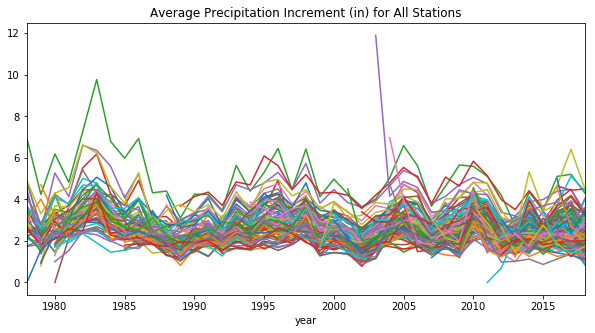

In [22]:
df_grouped = snowfall.groupby('Station Id')
for keys, group in df_grouped:
    group.groupby('year')['Precipitation Increment (in)'].mean().plot(figsize=(10,5), 
                                                                      title = 'Average Precipitation Increment (in) for All Stations')
    
plt.show()

In [23]:
stationgroups = snowfall[['Station Name', 'Precipitation Increment (in)']].groupby('Station Name')
stationPrecips = stationgroups['Precipitation Increment (in)'].mean()

stats = pd.DataFrame({'Precipitation Increment (in.) for Utah':['mean','min','max','standard deviation'],
                      'Values':[stationPrecips.mean(), min(stationPrecips), max(stationPrecips), np.std(stationPrecips)]})
stats

Precipitation Increment (in.) for Utah    Values
0                                   mean  2.510117
1                                    min  1.330769
2                                    max  5.045666
3                     standard deviation  0.632711

We can see here below that at least in one dimension there doesn't seem to be a relationship between average precipitation and elevation, which would make sense.  We think that we should be able to find a way to fit precipitation data once we have latitude and longitude data.  

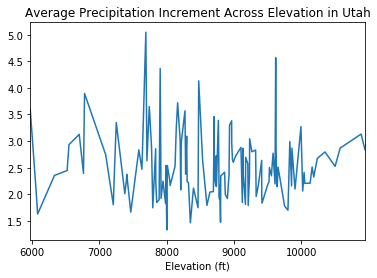

In [24]:
elevationgroups = snowfall.groupby('Elevation (ft)')
elevationPrecips = elevationgroups['Precipitation Increment (in)'].mean()
elevationPrecips.plot(title = 'Average Precipitation Increment Across Elevation in Utah')

In [25]:
yeargroups = snowfall.dropna().groupby('year')
yearprecips = yeargroups[['Air Temperature Average (degF)','Air Temperature Maximum (degF)',
                         'Air Temperature Minimum (degF)']].mean()
yearprecips.plot(title = 'Air Temperature in Utah, 1996 - 2018')
print('Temperature data begin in '+ str(min(snowfall.dropna()['year'])))

Temperature data begin in 1996


In [26]:
monthGroups = snowfall.dropna().groupby('month')
monthTemps = monthGroups[['Air Temperature Average (degF)','Air Temperature Maximum (degF)',
                         'Air Temperature Minimum (degF)']].mean()
monthTemps.index = pd.CategoricalIndex(monthprecips.index,
                                        categories = ['Jan','Feb','Mar','Apr','May','Jun',
                                                      'Jul','Aug','Sep','Oct','Nov','Dec'],
                                        sorted = True)
monthTemps.sort_index().plot(figsize = (10,5), title = 'Air Temperature in Utah (deg. F) by Month Over 1996-2018') #.axhline(y=32)



In [27]:
monthlySnow = snowfall.dropna().groupby('month')[['Snow Depth (in) Start of Month Values', 
                                                  'Snow Water Equivalent (in) Start of Month Values']].mean()

monthlySnow.index = pd.CategoricalIndex(monthprecips.index,
                                        categories = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],
                                        sorted = True)
monthlySnow.sort_index().plot(figsize = (10,5), title = 'Utah`s Snow by Month, 1996-2018')
print('Temperature data begin in '+ str(min(snowfall.dropna()['year'])))

Temperature data begin in 1996


Notice how snow depth peaks at the start of March, just when air temperatures begin to rise signifiantly.

## Web Scraping and Merging Datasets

This is the part of the document where we are starting to do the web scraping.  The original data set does not include latitude or longitude data for the sites, so we need to scrape that information from the webpages for the individual SNOTEL sites if we want to learn whether geographic location of the sites has any effect on precipitation.

We are able to get the websites easily enough, but it turns out that extracting the latitude and longitude data from the HTML is harder than we had anticipated, since those numbers are not between any type of HTML tag.  This has made using BeautifulSoup much harder than we initially had anticipated.  No problem, though -- we can use Regular Expressions (RegEx) to extract the numbers. Further below, we find a way to remove the junk from these and add them to the dataframe.

Note:  we saved the HTML webpages so that you do not need to run the (commented out) code just below -- see the bold header further down.

In [98]:
stationids = snowfall['Station Id']
stationList = stationids.unique()

In [99]:
import time
import requests
import urllib.request
from bs4 import BeautifulSoup

In [100]:
urls = []
for item in stationList:
    urls.append('https://wcc.sc.egov.usda.gov/nwcc/site?sitenum=' + str(item) + '&state=ut')
    

In [101]:
len(urls)

132

In [102]:
# responses = []
# for idx, url in enumerate(urls):
#    response = requests.get(url)
#    responses.append(response.text)
#    print('got the webpage')
#    if idx%10 == 0 and idx != 0:
#        time.sleep(2)
        

In [103]:
# with open('sitePages.html', 'w') as my_file:
#     my_file.write(str(responses))

In [32]:
soups = []
for response in responses:
    soup = BeautifulSoup(response, 'lxml')
    soups.append(soup)

In [24]:
# for br in soup.findAll('br'):
#     next_s = br.nextSibling
#     if not (next_s and isinstance(next_s,BeautifulSoup.NavigableString)):
#         continue
#     next2_s = next_s.nextSibling
#     if next2_s and isinstance(next2_s,Tag) and next2_s.name == 'br':
#         text = str(next_s).strip()
#         if text:
#             print("Found:", next_s)

AttributeError: type object 'BeautifulSoup' has no attribute 'NavigableString'

In [25]:
# row =  soups[0].find_all('td valign="top"', string='Latitude:')
# for r in row:
#     nextSib = r.nextSibling
#     while nextSib.name != 'strong' and nextSib is not None:
#             nextSib = nextSib.nextSibling
# print(nextSib.text)

NameError: name 'nextSib' is not defined

In [26]:
# for br in soups[0].find_all('br'):
#     if str(type(br.contents[0])) == '<class \'BeautifulSoup.NavigableString\'>':
#         print(br.contents)

IndexError: list index out of range

In [33]:
import re

# latitudes = []
# longitudes = []
# for i in range(len(urls)):
#     tds = soups[i].find_all('td')
#     latitudes.append(re.findall(r"</strong> +[0-9]{2} +deg; +[0-9]{1}[\s]|</strong> +[0-9]{2} +deg; +[0-9]{2}[\s]", str(tds)))
#     longitudes.append(re.findall(r"</strong> +[0-9][0-9][0-9] +deg; +[0-9]{2} |</strong> +[0-9][0-9][0-9] +deg; +[0-9]{1}", str(tds)))

# longitudes
#latitudes

[['</strong> 112 deg; 16 ', '</strong> 112 deg; 16 '],
 ['</strong> 110 deg; 50 ', '</strong> 110 deg; 50 '],
 ['</strong> 111 deg; 33 ', '</strong> 111 deg; 33 '],
 ['</strong> 111 deg; 6', '</strong> 111 deg; 6'],
 ['</strong> 111 deg; 57 ', '</strong> 111 deg; 57 '],
 ['</strong> 111 deg; 55 ', '</strong> 111 deg; 55 '],
 ['</strong> 112 deg; 15 ', '</strong> 112 deg; 15 '],
 ['</strong> 112 deg; 21 ', '</strong> 112 deg; 21 '],
 ['</strong> 111 deg; 36 ', '</strong> 111 deg; 36 '],
 ['</strong> 110 deg; 35 ', '</strong> 110 deg; 35 '],
 ['</strong> 112 deg; 9', '</strong> 112 deg; 9'],
 ['</strong> 112 deg; 1', '</strong> 112 deg; 1'],
 ['</strong> 112 deg; 0', '</strong> 112 deg; 0'],
 ['</strong> 112 deg; 51 ', '</strong> 112 deg; 51 '],
 ['</strong> 111 deg; 35 ', '</strong> 111 deg; 35 '],
 ['</strong> 110 deg; 35 ', '</strong> 110 deg; 35 '],
 ['</strong> 111 deg; 26 ', '</strong> 111 deg; 26 '],
 ['</strong> 110 deg; 40 ', '</strong> 110 deg; 40 '],
 ['</strong> 109 deg; 27 '

In [34]:
# longitude_numeric= []
# latitude_numeric = []
# for entry in longitudes:
#     block = entry[0].split(' ')
#     result = int(block[1]) + (float(block[3])/60)
#     longitude_numeric.append(result)
    
# for entry in latitudes:
#     block = entry[0].split(' ')
#     result = int(block[1]) + (float(block[3])/60)
#     latitude_numeric.append(result)    

In [34]:
##longitudes[0][0].split(' ')
#longitude_numeric[5]

111.91666666666667

In [35]:
# with open('latitudes_num.txt', 'w') as my_file:
#     my_file.write(str(latitude_numeric))
    
# with open('longitudes_num.txt', 'w') as my_file:
#     my_file.write(str(longitude_numeric))

In [37]:
# with open('latitudes.txt', 'w') as my_file:
#     my_file.write(str(latitudes))
    
# with open('longitudes.txt', 'w') as my_file:
#     my_file.write(str(longitudes))

## Load the longitude/latitude text files

In [196]:
with open('longitudes_num.txt','r') as data:
    longs = data.read()
test_longitude = longs.replace('[','').replace(']','').split(', ')
for idx, item in enumerate(test_longitude):
    test_longitude[idx]= float(item)
#test_longitude    

In [197]:
with open('latitudes_num.txt','r') as data:
    lats = data.read()
test_latitude = lats.replace('[','').replace(']','').split(', ')
for idx, item in enumerate(test_latitude):
    test_latitude[idx]= float(item)
#test_latitude   

Now that we have scraped the latitude and longitude data, we are going to add it to the dataframe.  We have two different dataframes --  the one that we used to create the different time series above (the 'snowfall' dataframe), and one that is built as just a list of the SNOTEL data collection sites ('sites', which gets loaded just below).

In [200]:
sites = pd.read_csv("snotel_sites.csv")

In [201]:
sites['Longitude'] = test_longitude
sites['Latitude'] = test_latitude

In [202]:
siteID = []
for site in sites['Data sites']:
    sitestuff = site.replace(':','').split(' ')
    number = sitestuff[1]
    siteID.append(number)

In [203]:
sites['Site ID'] = siteID

In [204]:
sites.head(10)

Data sites   Longitude   Latitude Site ID
0         #\tSNOTEL 907: Agua Canyon\t UT  112.266667  37.516667     907
1       #\tSNOTEL 992: Bear River RS\t UT  110.833333  40.883333     992
2         #\tSNOTEL 329: Beaver Dams\t UT  111.550000  39.133333     329
3       #\tSNOTEL 330: Beaver Divide\t UT  111.100000  40.616667     330
4     #\tSNOTEL 332: Ben Lomond Peak\t UT  111.950000  41.383333     332
5    #\tSNOTEL 333: Ben Lomond Trail\t UT  111.916667  41.383333     333
6       #\tSNOTEL 1214: Bevans Cabin\t UT  112.250000  40.466667    1214
7            #\tSNOTEL 339: Big Flat\t UT  112.350000  38.300000     339
8  #\tSNOTEL 348: Black Flat-U.M. Ck\t UT  111.600000  38.683333     348
9    #\tSNOTEL 1162: Blacks Fork Jct\t UT  110.583333  40.950000    1162

In [28]:
sites['Site ID'] = pd.to_numeric(sites['Site ID'])

Now we create a dictionary, where the keys are the site ID numbers, and the values are the longitude/latitude data we scraped. The idea is to use this dictionary to define a mapping on the dataframe 'snowfall' which will fill new columns with latitude and longitude for each site.

In [29]:
keys = sites['Site ID']
values = sites['Longitude']
values_lat = sites['Latitude']
long_dict = dict(zip(keys,values))
lat_dict = dict(zip(keys,values_lat))

Now to define the mapping we make the indexes for 'snowfall' and 'sites' both be the Site ID numbers.

In [31]:
sites.set_index('Site ID')

Unnamed: 0  Unnamed: 0.1                                Data sites  \
Site ID                                                                       
907               0             0           #\tSNOTEL 907: Agua Canyon\t UT   
992               1             1         #\tSNOTEL 992: Bear River RS\t UT   
329               2             2           #\tSNOTEL 329: Beaver Dams\t UT   
330               3             3         #\tSNOTEL 330: Beaver Divide\t UT   
332               4             4       #\tSNOTEL 332: Ben Lomond Peak\t UT   
333               5             5      #\tSNOTEL 333: Ben Lomond Trail\t UT   
1214              6             6         #\tSNOTEL 1214: Bevans Cabin\t UT   
339               7             7              #\tSNOTEL 339: Big Flat\t UT   
348               8             8    #\tSNOTEL 348: Black Flat-U.M. Ck\t UT   
1162              9             9      #\tSNOTEL 1162: Blacks Fork Jct\t UT   
1278             10            10          #\tSNOTEL 1278: Bobs Hollow\t UT   
364              11            11             #\tSNOTEL 364: Box Creek\t UT   
1156             12            12          #\tSNOTEL 1156: Box Springs\t UT   
1154             13            13           #\tSNOTEL 1154: Brian Head\t UT   
366              14            14              #\tSNOTEL 366: Brighton\t UT   
368              15            15            #\tSNOTEL 368: Brown Duck\t UT   
371              16            16             #\tSNOTEL 371: Buck Flat\t UT   
1192             17            17         #\tSNOTEL 1192: Buck Pasture\t UT   
1153             18            18       #\tSNOTEL 1153: Buckboard Flat\t UT   
374              19            19              #\tSNOTEL 374: Bug Lake\t UT   
1135             20            20   #\tSNOTEL 1135: Burts Miller Ranch\t UT   
383              21            21          #\tSNOTEL 383: Camp Jackson\t UT   
1039             22            22     #\tSNOTEL 1039: Cascade Mountain\t UT   
390              23            23         #\tSNOTEL 390: Castle Valley\t UT   
392              24            24        #\tSNOTEL 392: Chalk Creek #1\t UT   
393              25            25        #\tSNOTEL 393: Chalk Creek #2\t UT   
396              26            26               #\tSNOTEL 396: Chepeta\t UT   
983              27            27       #\tSNOTEL 983: Clayton Springs\t UT   
399              28            28        #\tSNOTEL 399: Clear Creek #1\t UT   
400              29            29        #\tSNOTEL 400: Clear Creek #2\t UT   
...             ...           ...                                       ...   
1217            102           102            #\tSNOTEL 1217: Rees Flat\t UT   
720             103           103            #\tSNOTEL 720: Rock Creek\t UT   
723             104           104  #\tSNOTEL 723: Rocky Basin-Settleme\t UT   
1280            105           105    #\tSNOTEL 1280: Santaquin Meadows\t UT   
742             106           106          #\tSNOTEL 742: Seeley Creek\t UT   
763             107           107      #\tSNOTEL 763: Smith  Morehouse\t UT   
766             108           108              #\tSNOTEL 766: Snowbird\t UT   
1117            109           109            #\tSNOTEL 1117: Spirit Lk\t UT   
790             110           110      #\tSNOTEL 790: Steel Creek Park\t UT   
795             111           111     #\tSNOTEL 795: Strawberry Divide\t UT   
1249            112           112       #\tSNOTEL 1249: Sunflower Flat\t UT   
1248            113           113            #\tSNOTEL 1248: Suu Ranch\t UT   
1247            114           114          #\tSNOTEL 1247: Takka Wiiya\t UT   
1013            115           115          #\tSNOTEL 1013: Temple Fork\t UT   
814             116           116        #\tSNOTEL 814: Thaynes Canyon\t UT   
1226            117           117         #\tSNOTEL 1226: Thistle Flat\t UT   
1097            118           118           #\tSNOTEL 1097: Timberline\t UT   
820             119           119     #\tSNOTEL 820: Timpan

In [32]:
snowfall.set_index('Station Id')

Date      Station Name  Elevation (ft)  \
Station Id                                             
907         Oct-94       Agua Canyon            8900   
907         Nov-94       Agua Canyon            8900   
907         Dec-94       Agua Canyon            8900   
907         Jan-95       Agua Canyon            8900   
907         Feb-95       Agua Canyon            8900   
907         Mar-95       Agua Canyon            8900   
907         Apr-95       Agua Canyon            8900   
907         May-95       Agua Canyon            8900   
907         Jun-95       Agua Canyon            8900   
907         Jul-95       Agua Canyon            8900   
907         Aug-95       Agua Canyon            8900   
907         Sep-95       Agua Canyon            8900   
907         Oct-95       Agua Canyon            8900   
907         Nov-95       Agua Canyon            8900   
907         Dec-95       Agua Canyon            8900   
907         Jan-96       Agua Canyon            8900   
907         Feb-96       Agua Canyon            8900   
907         Mar-96       Agua Canyon            8900   
907         Apr-96       Agua Canyon            8900   
907         May-96       Agua Canyon            8900   
907         Jun-96       Agua Canyon            8900   
907         Jul-96       Agua Canyon            8900   
907         Aug-96       Agua Canyon            8900   
907         Sep-96       Agua Canyon            8900   
907         Oct-96       Agua Canyon            8900   
907         Nov-96       Agua Canyon            8900   
907         Dec-96       Agua Canyon            8900   
907         Jan-97       Agua Canyon            8900   
907         Feb-97       Agua Canyon            8900   
907         Mar-97       Agua Canyon            8900   
...            ...               ...             ...   
1197        Oct-15  Yankee Reservoir            8692   
1197        Nov-15  Yankee Reservoir            8692   
1197        Dec-15  Yankee Reservoir            8692   
1197        Jan-16  Yankee Reservoir            8692   
1197        Feb-16  Yankee Reservoir            8692   
1197        Mar-16  Yankee Reservoir            8692   
1197        Apr-16  Yankee Reservoir            8692   
1197        May-16  Yankee Reservoir            8692   
1197        Jun-16  Yankee Reservoir            8692   
1197        Jul-16  Yankee Reservoir            8692   
1197        Aug-16  Yankee Reservoir            8692   
1197        Sep-16  Yankee Reservoir            8692   
1197        Oct-16  Yankee Reservoir            8692   
1197        Nov-16  Yankee Reservoir            8692   
1197        Dec-16  Yankee Reservoir            8692   
1197        Jan-17  Yankee Reservoir            8692   
1197        Feb-17  Yankee Reservoir            8692   
1197        Mar-17  Yankee Reservoir            8692   
1197        Apr-17  Yankee Reservoir            8692   
1197        May-17  Yankee Reservoir            8692   
1197        Jun-17  Yankee Reservoir            8692   
1197        Jul-17  Yankee Reservoir            8692   
1197        Aug-17  Yankee Reservoir            8692   
1197        Sep-17  Yankee Reservoir            8692   
1197        Oct-17  Yankee Reservoir            8692   
1197        Nov-17  Yankee Reservoir            8692   
1197        Dec-17  Yankee Reservoir            8692   
1197        Jan-18  Yankee Reservoir            8692   
1197        Feb-18  Yankee Reservoir            8692   
1197        Mar-18  Yankee Reservoir            8692   

            Precipitation Accumulation (in) Start of Month Values  \
Station Id                                                          
907                                                       0.0       
907                                                       2.0       
907                                                       4.8       
907                                                       7.5       
907                                                      13.1       
90

In [33]:
snowfall['Longitude'] = np.nan
snowfall['Latitude'] = np.nan

In [34]:
snowfall['Longitude'] = snowfall['Station Id'].map(long_dict)
snowfall['Latitude'] = snowfall['Station Id'].map(lat_dict)

In [35]:
sites.dtypes

Unnamed: 0        int64
Unnamed: 0.1      int64
Data sites       object
Longitude       float64
Latitude        float64
Site ID           int64
Avg Precip      float64
Elevation         int64
dtype: object

Look!  Now the longitude and latitude are in 'snowfall'.

In [36]:
snowfall.head()

Date  Station Id Station Name  Elevation (ft)  \
0  Oct-94         907  Agua Canyon            8900   
1  Nov-94         907  Agua Canyon            8900   
2  Dec-94         907  Agua Canyon            8900   
3  Jan-95         907  Agua Canyon            8900   
4  Feb-95         907  Agua Canyon            8900   

   Precipitation Accumulation (in) Start of Month Values  \
0                                                0.0       
1                                                2.0       
2                                                4.8       
3                                                7.5       
4                                               13.1       

   Precipitation Increment (in)  \
0                           2.0   
1                           2.8   
2                           2.7   
3                           5.6   
4                           3.0   

   Snow Water Equivalent (in) Start of Month Values  \
0                                               0.0   
1                                               0.0   
2                                               2.3   
3                                               4.7   
4                                              10.5   

   Snow Depth (in) Start of Month Values  Air Temperature Average (degF)  \
0                                    NaN                             NaN   
1                                    NaN                             NaN   
2                                    NaN                             NaN   
3                                    NaN                             NaN   
4                                    NaN                             NaN   

   Air Temperature Maximum (degF)  Air Temperature Minimum (degF)  year month  \
0                             NaN                             NaN  1994   Oct   
1                             NaN                             NaN  1994   Nov   
2                             NaN                             NaN  1994   Dec   
3                             NaN                             NaN  1995   Jan   
4                             NaN                             NaN  1995   Feb   

    Longitude   Latitude  
0 -112.266667  37.516667  
1 -112.266667  37.516667  
2 -112.266667  37.516667  
3 -112.266667  37.516667  
4 -112.266667  37.516667

## Unsupervised Learning (Cluster Analysis) and Visualization
### We finally had a useful dataset that could be used to analyze more interesting trends

Basically, we want to investigate whether the data can discern different climates in the state.  Are some areas very wet?  Are some of the sites in desert regions?  If the SNOTEL sites can be grouped into different clusters based on precipitation, snowfall, temperature, and so on, it stands to reason that the state has qualitatively distinct climates.

In [37]:
plt.scatter(sites['Longitude'],sites['Latitude'])
plt.title('Coordinates of SNOTEL Sites')

Text(0.5,1,'Coordinates of SNOTEL Sites')

Now that we have a rudimentary plot, we will use the plotly package to create a much nicer looking plot that overlays the site locations over a map of the state.  
(In order to see the map, you may need to first install plotly)
### Please Zoom in on the map.

In [38]:
import plotly
plotly.offline.init_notebook_mode(connected=True)
scl = [ [0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
    [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"] ]

data = [ dict(
        type = 'scattergeo',
        locationmode = 'ISO-3',
        lon = sites['Longitude'],
        lat = sites['Latitude'],
        text = stationPrecips,
        mode = 'markers',
        marker = dict(
            size = 8,
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = 'square',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = scl,
            cmin = 0,
            color = stationPrecips,
            cmax = max(stationPrecips),
            colorbar=dict(
                title="Average Monthly Precipitation"
            )
        ))]

layout = dict(
        title = 'Snotel Sites (please zoom in)',
        colorbar = False,
        geo = dict(
            scope='utah',
            projection=dict( type='albers usa' ),
            showland = True,
            landcolor = "rgb(240, 240, 240)",
            subunitcolor = "rgb(170, 170, 170)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5
        ),
    )

fig = dict( data=data, layout=layout )
plotly.offline.iplot( fig, validate=False, filename='snotel sites' )

See how the north generally seems to get more precipitation than other areas in the state?  Also, this map looks surprisingly similar to another map we've seen:  

![Population density map Utah](Utah-State-Population-Density-Map.jpg)  
It would seem that the snotel sites are concentrated along areas of the state where the population is greater. This would make sense given that within the state, most agricultural activity happens quite close to established population centers.   
We can compare the locations of the collection points to the data on a few more maps such as an elevation map of utah
![Elevation Relief Map Utah](State Elevation Map.jpg)  
You might notice that both people and these stations seem to follow along with the locations of a major mountain range running from the northeast to the southwest.

In [39]:
print('The lowest-elevation station is at ' + str(snowfall['Elevation (ft)'].min()) + ' ft')

The lowest-elevation station is at 5972 ft


So, some of the lowest areas in the state are not represnted by the station data.

In [40]:
#snowfall.to_csv('full dataset.csv')
snowfall = pd.read_csv('full dataset.csv')
sites = pd.read_csv('siteLoc.csv')

snowfall.head()

Unnamed: 0    Date  Station Id Station Name  Elevation (ft)  \
0           0  Oct-94         907  Agua Canyon            8900   
1           1  Nov-94         907  Agua Canyon            8900   
2           2  Dec-94         907  Agua Canyon            8900   
3           3  Jan-95         907  Agua Canyon            8900   
4           4  Feb-95         907  Agua Canyon            8900   

   Precipitation Accumulation (in) Start of Month Values  \
0                                                0.0       
1                                                2.0       
2                                                4.8       
3                                                7.5       
4                                               13.1       

   Precipitation Increment (in)  \
0                           2.0   
1                           2.8   
2                           2.7   
3                           5.6   
4                           3.0   

   Snow Water Equivalent (in) Start of Month Values  \
0                                               0.0   
1                                               0.0   
2                                               2.3   
3                                               4.7   
4                                              10.5   

   Snow Depth (in) Start of Month Values  Air Temperature Average (degF)  \
0                                    NaN                             NaN   
1                                    NaN                             NaN   
2                                    NaN                             NaN   
3                                    NaN                             NaN   
4                                    NaN                             NaN   

   Air Temperature Maximum (degF)  Air Temperature Minimum (degF)  year month  \
0                             NaN                             NaN  1994   Oct   
1                             NaN                             NaN  1994   Nov   
2                             NaN                             NaN  1994   Dec   
3                             NaN                             NaN  1995   Jan   
4                             NaN                             NaN  1995   Feb   

    Longitude   Latitude  
0  112.266667  37.516667  
1  112.266667  37.516667  
2  112.266667  37.516667  
3  112.266667  37.516667  
4  112.266667  37.516667

This plot shows the total rainfall by station each year, it is a messy plot, but you can see some trends occurring.  The low portion on the right end of the graph is indicative of the partial water year beginning in october 2017 that has yet to finish.

## Preparing the Dataset for Clustering Analysis

In [41]:
siteSet = snowfall.groupby('Station Id')
sitePrecip = siteSet['Precipitation Increment (in)'].mean()
sitePrecip
#sites['Avg Precip'] = sitePrecip
#sites

#Change longitude values to negative
sites[['Longitude']] *= -1

values_precip = sitePrecip
precip_dict = dict(zip(keys,values_precip))
precip_dict
sites['Avg Precip'] = sites['Site ID'].map(precip_dict)
siteEl = siteSet['Elevation (ft)'].max()
sites['Elevation'] = siteEl
values_el = siteEl
el_dict = dict(zip(keys,values_el))
sites['Elevation'] = sites['Site ID'].map(el_dict)
sites

Unnamed: 0  Unnamed: 0.1                                Data sites  \
0             0             0           #\tSNOTEL 907: Agua Canyon\t UT   
1             1             1         #\tSNOTEL 992: Bear River RS\t UT   
2             2             2           #\tSNOTEL 329: Beaver Dams\t UT   
3             3             3         #\tSNOTEL 330: Beaver Divide\t UT   
4             4             4       #\tSNOTEL 332: Ben Lomond Peak\t UT   
5             5             5      #\tSNOTEL 333: Ben Lomond Trail\t UT   
6             6             6         #\tSNOTEL 1214: Bevans Cabin\t UT   
7             7             7              #\tSNOTEL 339: Big Flat\t UT   
8             8             8    #\tSNOTEL 348: Black Flat-U.M. Ck\t UT   
9             9             9      #\tSNOTEL 1162: Blacks Fork Jct\t UT   
10           10            10          #\tSNOTEL 1278: Bobs Hollow\t UT   
11           11            11             #\tSNOTEL 364: Box Creek\t UT   
12           12            12          #\tSNOTEL 1156: Box Springs\t UT   
13           13            13           #\tSNOTEL 1154: Brian Head\t UT   
14           14            14              #\tSNOTEL 366: Brighton\t UT   
15           15            15            #\tSNOTEL 368: Brown Duck\t UT   
16           16            16             #\tSNOTEL 371: Buck Flat\t UT   
17           17            17         #\tSNOTEL 1192: Buck Pasture\t UT   
18           18            18       #\tSNOTEL 1153: Buckboard Flat\t UT   
19           19            19              #\tSNOTEL 374: Bug Lake\t UT   
20           20            20   #\tSNOTEL 1135: Burts Miller Ranch\t UT   
21           21            21          #\tSNOTEL 383: Camp Jackson\t UT   
22           22            22     #\tSNOTEL 1039: Cascade Mountain\t UT   
23           23            23         #\tSNOTEL 390: Castle Valley\t UT   
24           24            24        #\tSNOTEL 392: Chalk Creek #1\t UT   
25           25            25        #\tSNOTEL 393: Chalk Creek #2\t UT   
26           26            26               #\tSNOTEL 396: Chepeta\t UT   
27           27            27       #\tSNOTEL 983: Clayton Springs\t UT   
28           28            28        #\tSNOTEL 399: Clear Creek #1\t UT   
29           29            29        #\tSNOTEL 400: Clear Creek #2\t UT   
..          ...           ...                                       ...   
102         102           102            #\tSNOTEL 1217: Rees Flat\t UT   
103         103           103            #\tSNOTEL 720: Rock Creek\t UT   
104         104           104  #\tSNOTEL 723: Rocky Basin-Settleme\t UT   
105         105           105    #\tSNOTEL 1280: Santaquin Meadows\t UT   
106         106           106          #\tSNOTEL 742: Seeley Creek\t UT   
107         107           107      #\tSNOTEL 763: Smith  Morehouse\t UT   
108         108           108              #\tSNOTEL 766: Snowbird\t UT   
109         109           109            #\tSNOTEL 1117: Spirit Lk\t UT   
110         110           110      #\tSNOTEL 790: Steel Creek Park\t UT   
111         111           111     #\tSNOTEL 795: Strawberry Divide\t UT   
112         112           112       #\tSNOTEL 1249: Sunflower Flat\t UT   
113         113           113            #\tSNOTEL 1248: Suu Ranch\t UT   
114         114           114          #\tSNOTEL 1247: Takka Wiiya\t UT   
115         115           115          #\tSNOTEL 1013: Temple Fork\t UT   
116         116           116        #\tSNOTEL 814: Thaynes Canyon\t UT   
117         117           117         #\tSNOTEL 1226: Thistle Flat\t UT   
118         118           118           #\tSNOTEL 1097: Timberline\t UT   
119         119           119     #\tSNOTEL 820: Timpanogos Divide\t UT   
120         120           120       #\tSNOTEL 823: Tony Grove Lake\t UT   
121         121           121        #\tSNOTEL 1113: Tony Grove RS\t UT   
122         122           122            #\tSNOTEL 828: Trial Lake\t UT   
123         123           123 

In [42]:
#sites.to_csv('siteLoc.csv')

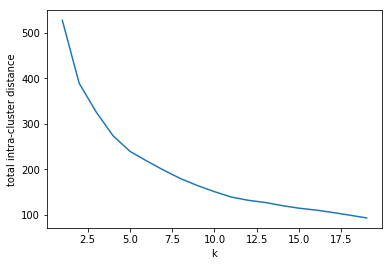

In [43]:
#This code block contains K-means clustering analysis on sites data.
#Should be placed in Exploratory Analysis section of final document

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import scale

sites = pd.read_csv("siteLoc.csv")

k_data = sites[["Elevation","Avg Precip","Longitude","Latitude"]]
#X = k_data.as_matrix()
X = scale(k_data.as_matrix())
#print(X)

#Determine best K value for K-means clustering analysis
ks = range(1,20)
scores = []
for k in ks:
    model = KMeans(n_clusters=k, n_init=100)
    model.fit_predict(X)
    scores.append(-model.score(X))

plt.plot(ks, scores)
plt.ylabel('total intra-cluster distance')
plt.xlabel('k')
plt.show()

The rate of change in intra-cluster distance begins to diminish after 12. So we'll run a K-means clustering test with k = 12 clusters and visualize the results on two separate plots. One for latitude and longitude. One for elevation and average precipitation.

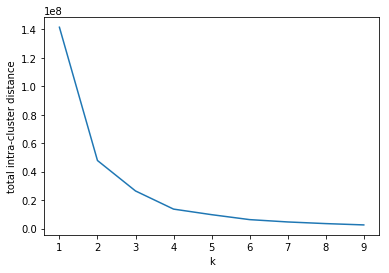

In [44]:
#Here is the same test but without scaling

X_ns = k_data.as_matrix()

#Determine best K value for K-means clustering analysis
ks = range(1,10)
scores = []
for k in ks:
    model = KMeans(n_clusters=k, n_init=100)
    model.fit_predict(X_ns)
    scores.append(-model.score(X_ns))

plt.plot(ks, scores)
plt.ylabel('total intra-cluster distance')
plt.xlabel('k')
plt.show()

Without scaling, the rate of change in intra-cluster distance diminishes around k = 4. Much lower than with scaling.  When plotted, the clusters are almost entirely dependent on the unscaled elevation, which has the largest numerical range of any of the factors we are using for the clustering.  This shows the importance of scaling your data.

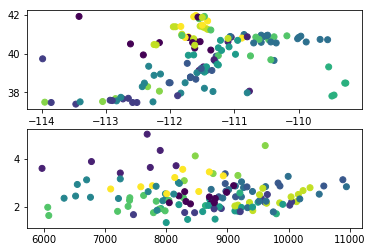

In [45]:
#Here's the K-means cluster analysis with k=12 for the scaled data. Produces two plots.

from matplotlib.colors import ListedColormap
X = scale(k_data.as_matrix())
y_pred = KMeans(n_clusters=12,n_init=100).fit_predict(X)

f, cluster_results = plt.subplots(2, sharex=False, sharey=False)

#plot latitude against longitude
cluster_results[0].scatter(k_data["Longitude"], k_data["Latitude"], c=y_pred,  marker="o")

#plot elevation against precipitation                               
cluster_results[1].scatter(k_data["Elevation"], k_data["Avg Precip"], c=y_pred,  marker="o")
                                        
plt.show()

In [66]:
sites['Elevation']
siteText = dict(zip(keys, sites['Elevation']))
siteText = ['Cluster '+str(x) + ', ' + str(y) + ' feet, '+ str(z) + 
            ' inches precip/month' for x, y, z in zip(y_pred, sites['Elevation'], sites['Avg Precip'])]

In [47]:
import plotly
plotly.offline.init_notebook_mode(connected=True)
scl = [ [0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 240, 190)"],[0.5,"rgb(20, 200, 24)"],\
    [0.6,"rgb(190, 120, 24)"],[0.7,"rgb(200, 200, 247)"],[1,"rgb(220, 22, 11)"] ]

data = [ dict(
        type = 'scattergeo',
        locationmode = 'ISO-3',
        lon = sites['Longitude'],
        lat = sites['Latitude'],
        text = siteText,
        mode = 'markers',
        marker = dict(
            size = 8,
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = 'square',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = scl,
            cmin = 0,
            color = y_pred,
            cmax = max(y_pred),
            colorbar=dict(
                title="Cluster Group"
            )
        ))]

layout = dict(
        title = 'Snotel Sites (K-Means Clustering)',
        colorbar = False,
        geo = dict(
            scope='utah',
            projection=dict( type='albers usa' ),
            showland = True,
            landcolor = "rgb(240, 240, 240)",
            subunitcolor = "rgb(170, 170, 170)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5
        ),
    )

fig = dict( data=data, layout=layout )
plotly.offline.iplot( fig, validate=False, filename='snotel sites' )

Among all of the clusters, the one corresponding to the sites in the Uintas is the most distinct, and the most compact of all of the clusters when viewed geographically, this indicates that the Uintah Mountains are the quite distinct geographically and weather wise.  Geography seems to play a role.

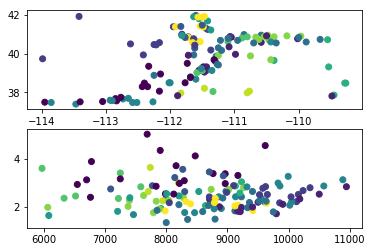

In [48]:
k_data = sites[["Elevation","Avg Precip","Longitude","Latitude"]]
#X = k_data.as_matrix()
X = scale(k_data.as_matrix())

agg_cluster_model = AgglomerativeClustering(linkage="average", affinity='correlation', n_clusters=12)
y_pred_Agg = agg_cluster_model.fit_predict(X)

f, cluster_results = plt.subplots(2, sharex=False, sharey=False)

#plot latitude against longitude
cluster_results[0].scatter(k_data["Longitude"], k_data["Latitude"], c=y_pred_Agg,  marker="o")

#plot elevation against precipitation                               
cluster_results[1].scatter(k_data["Elevation"], k_data["Avg Precip"], c=y_pred_Agg,  marker="o")
                                        
plt.show()

In [49]:
sites['Elevation']
siteText_Agg = dict(zip(keys, sites['Elevation']))
siteText

siteText_Agg = ['Cluster '+str(x) + ', ' + str(y) + ' feet, '+ str(z) + ' inches precip/month' for x, y, z in zip(y_pred_Agg, sites['Elevation'], sites['Avg Precip'])]

In [50]:
import plotly
plotly.offline.init_notebook_mode(connected=True)
scl = [ [0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 240, 190)"],[0.5,"rgb(20, 200, 24)"],\
    [0.6,"rgb(190, 120, 24)"],[0.7,"rgb(200, 200, 247)"],[1,"rgb(220, 22, 11)"] ]

data = [ dict(
        type = 'scattergeo',
        locationmode = 'ISO-3',
        lon = sites['Longitude'],
        lat = sites['Latitude'],
        text = siteText_Agg,
        mode = 'markers',
        marker = dict(
            size = 8,
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = 'square',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = scl,
            cmin = 0,
            color = y_pred,
            cmax = max(y_pred),
            colorbar=dict(
                title="Cluster Group"
            )
        ))]

layout = dict(
        title = 'Snotel Sites (Agglomerative Clustering)',
        colorbar = False,
        geo = dict(
            scope='utah',
            projection=dict( type='albers usa' ),
            showland = True,
            landcolor = "rgb(240, 240, 240)",
            subunitcolor = "rgb(170, 170, 170)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5
        ),
    )

fig = dict( data=data, layout=layout )
plotly.offline.iplot( fig, validate=False, filename='snotel sites' )

Even using a different clustering method we still have a cluster centered around the Uintas, and others that roughly correspond to different areas in the state.  Some clusters have more spatial spread than others.  Both methods found robust clusters in the Uintas, indicating a strong similarity between the Uintah Sites.

Text(0.5,1,'Agglomerative Clustering')

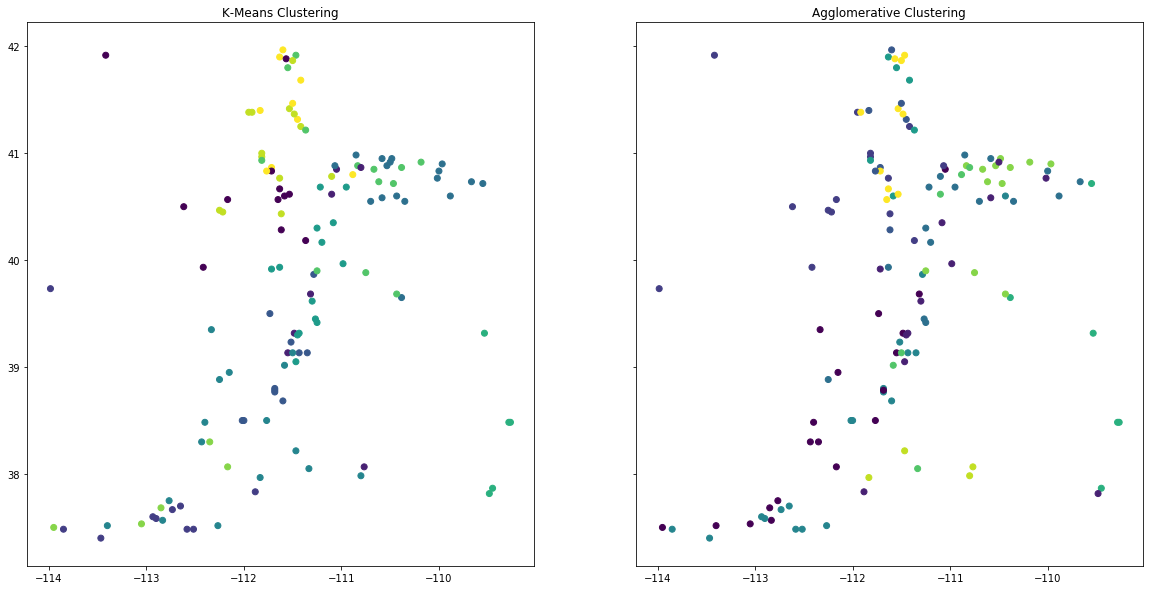

In [51]:
f, (cluster_results1, cluster_results2) = plt.subplots(1, 2, sharex=False, sharey=True,figsize=(20,10))

#plot latitude against longitude
cluster_results1.scatter(k_data["Longitude"], k_data["Latitude"], c=y_pred,  marker="o")
cluster_results1.set_title('K-Means Clustering')
cluster_results2.scatter(k_data["Longitude"], k_data["Latitude"], c=y_pred_Agg,  marker="o")
cluster_results2.set_title('Agglomerative Clustering')


Even though there is some variation in how the clusters are distributed between the two clustering methods, we still see quite a bit of similarity between the clusters generated.

Estimated number of clusters: 5


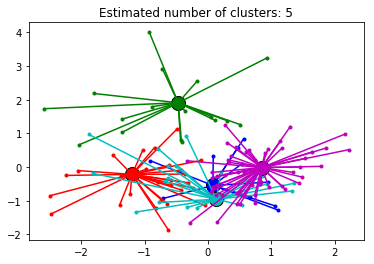

In [52]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs

# #############################################################################
# Generate sample data
#centers = [[1, 1], [-1, -1], [1, -1]]
#X, labels_true = make_blobs(n_samples=300, centers=centers, cluster_std=0.5,
#                            random_state=0)
k_data = sites[["Elevation","Avg Precip","Longitude","Latitude"]]
#X = k_data.as_matrix()
X = scale(k_data.as_matrix())



# #############################################################################
# Compute Affinity Propagation
af = AffinityPropagation(preference=-50).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)
#print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
#print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
#print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
#print("Adjusted Rand Index: %0.3f"
#      % metrics.adjusted_rand_score(labels_true, labels))
# print("Adjusted Mutual Information: %0.3f"
#       % metrics.adjusted_mutual_info_score(labels_true, labels))
# print("Silhouette Coefficient: %0.3f"
#       % metrics.silhouette_score(X, labels, metric='sqeuclidean'))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

We attempted to run an Affinity Propagation clustering, which required a scaled version of the data, unfortunately, due to the nature of the output, we were unable to find a nice interpretation of this model.  It seems that it is creating some similar groupings to the ones we created with the otherclustering methods, but without being able to unscale the data, we are at a loss for how to fully interpret the output.

## Conclusion
We think our results were pretty heavily influenced by the placement of the stations along the most highly populated regions of the state, i.e. where there may be more rainfall compared to non-populated areas of the state.  If there were more stations located within the desert flatland areas, we would be seeing much more interesting variation in our data. Some of the clusters we see are not readily characterized by geographic location in the state, but others are. The data are are weakly clustered with respect to elevation. Presumably, kMeans and Agglomerative clustering were able to find similarities between groups of SNOTEL sites based on their microclimates' characteristics; but with the exception of certain groups of sites, there are no broad, generalizable distinctions to be made between the different sites.

We think the data may not accurately represent the climate of the state as a whole, because the stations are located in regions of agricultural interest, rather than being randomly distributed through the state. This is readily apparent upon inspecting the maps.  We also learned that weather data is not influenced by a single factor, and in fact, we often see that the clustering was very heavily influenced by the other factors available to the method, making visualization very difficult.  

The Uintah Mountains seemed to be a region that was rather unique and consistently clustered together during the analysis phase.  We had been hoping to see some more sites like those, and indeed some of the clusters are confined to a limited geographic span, but most clusters overlap with others.

## What We learned
Weather and time series data are very hard to work with. Cleaning the data took quite a lot of time, but even once we did this some of the things that we had initially desired to have in our final project had to be dropped.  For example, we had the hoped to include the temperature data into our analysis, with a view to use precipitation to predict temperature, and vice versa.  The temperature data were sparse, so we did not attempt this.

We also had to deal with a surprisingly difficult bit of web scraping, which was made challenging by the lack of any html tags around the information we wanted.  We had to use a complicated combination of BeautifulSoup and very rigid Regular Expressions to finally get the data off of the sites. It then took another while before we were actually able to get the location data which we wanted to be in a format that would allow it to be combined with the other datasets.

We see some evidence for distinct climates within the state, as well as cycles of precipitation over the period 1978 - 2018. We observed slight decline in rainfall since 1978, as well as in snowdepth since 1995.  We saw slight increase in air temperatures from 1996 - 2018.